# Running Trained GO model and LM

### By Jianfeng Ke
#### 02/27/20234

In [1]:
# import pytorch libraries
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import GATConv
from torch_geometric.data import Data
from torch_geometric.deprecation import deprecated

import os
import csv
import copy
import math
import time
import random
import argparse
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tools.eval_measures import mse
from scipy import stats
from scipy.stats import norm
from scipy.stats import spearmanr
from scipy.spatial.distance import cosine
import matplotlib.pyplot as plt

In [2]:
# initial settings
# train the model on GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#pick_gtex_region = 'Amygdala'
# pick_gtex_region = 'Anterior_cingulate_cortex_BA24'
# pick_gtex_region = 'Caudate_basal_ganglia'
pick_gtex_region = 'Cerebellar_Hemisphere'
# pick_gtex_region = 'Frontal_Cortex_BA9'
# pick_gtex_region = 'Hippocampus'
# pick_gtex_region = 'Hypothalamus'
# pick_gtex_region = 'Nucleus_accumbens_basal_ganglia'
# pick_gtex_region = 'Putamen_basal_ganglia'
# pick_gtex_region = 'Substantia_nigra'

# name difference
if pick_gtex_region=='Cerebellar_Hemisphere':
    allen_name='Cerebellum'
elif pick_gtex_region=='Frontal_Cortex_BA9':
    allen_name='Cortex'
else:
    allen_name=pick_gtex_region

# settings
all_ids = ['10021', '12876', '14380', '15496', '15697', '9861']

# path
allen_data_path = '/project/pi_rachel_melamed_uml_edu/Jianfeng/Allen/data/allen_data/allen/'
save_path = '/project/pi_rachel_melamed_uml_edu/Jianfeng/Allen/data/allen_data/quantile_normalized_allen/'

GeneExpression_allen_dict = {}
# iterate over all 6 subjects
for i in range(len(all_ids)):
    donor = all_ids[i]
    file_name = save_path + "normalized_expr_" + donor + ".csv"
    normalized_mat = pd.read_csv(file_name, header = 0)
    normalized_mat = normalized_mat.set_index('gene_symbol')
    GeneExpression_allen_dict[donor] = normalized_mat
    
    
ontology_path = allen_data_path + 'normalized_microarray_donor' + '9861' + '/Ontology.csv'
ontology = pd.read_csv(ontology_path, header = 0)
# From the ontology file, find the sub-regions in allen under gtex region
gtex_map_path = allen_data_path + "map_gtex_structure.txt"
gTex_map_dict = {}
print("Total number of regions in allen ontology:", ontology.shape[0])
for i in open(gtex_map_path):
    i = i.strip().split("\t")
    gtex_region = i[0].strip()
    allen_region = i[1].strip()
    if((allen_region == "none?") | (allen_region == 'pituitary body')):
        continue
    covered_allen_region = ontology.loc[(ontology['name']==allen_region) | ontology['structure_id_path'].str.startswith(ontology.loc[ontology['name']==allen_region, 'structure_id_path'].values[0]), 'id']
    gTex_map_dict[gtex_region] = covered_allen_region.tolist()
    print(gtex_region, "-->", allen_region, ";  number of regions in allen:", len(covered_allen_region))
print("\n")
    
    
intersected_region = GeneExpression_allen_dict['9861'].columns.tolist()
used_intersected_region_dict = {}
# unseen_intersected_region_dict = {}
for gtex_region, covered_allen_region in gTex_map_dict.items():
    used_region_list = [x for x in intersected_region if int(x) in covered_allen_region]
    used_intersected_region_dict[gtex_region] = used_region_list
    print(gtex_region, " # regions expired:", len(used_region_list))
num_used_region = sum(len(value) for value in used_intersected_region_dict.values())
print("Total number of intersected region between allen and gtex:", len(intersected_region))
print("Total number of used allen region for generating regions for gtex:", num_used_region)
print("Total number of unseen allen regions when generating regions for gtex:", len(intersected_region)-num_used_region)
print("\n")


# read the summarized allen data (in gtex format) into a dictionary
save_path = '/project/pi_rachel_melamed_uml_edu/Jianfeng/Allen/data/allen_data/quantile_normalized_allen/'
# find the file and read it into a dictionary
summarized_gtex_dict = {}
for file_name in os.listdir(save_path):
    if file_name.endswith('-gtex.txt'):
        key = file_name.split('-gtex.txt')[0]
        file_path = os.path.join(save_path, file_name)
        mat = pd.read_csv(file_path, sep='\t', index_col=0)
        #mat = mat.iloc[:-1]
        # Store the dataframe in the dictionary with the key
        summarized_gtex_dict[key] = mat
        

# Load gtex data
data_dir = '/project/pi_rachel_melamed_uml_edu/Jianfeng/Allen/src/Pytorch/12052023/'
gt = pd.read_csv(data_dir+"new_normed_gtex_gtex_allen_gene.txt", low_memory=False, index_col=0, sep="\t")
region_pick = ['Amygdala', 'Anterior_cingulate_cortex_BA24', 'Caudate_basal_ganglia', 
               'Cerebellar_Hemisphere', 'Frontal_Cortex_BA9', 'Hippocampus', 'Hypothalamus', 
               'Nucleus_accumbens_basal_ganglia', 'Putamen_basal_ganglia', 'Substantia_nigra']
# build a dictionary to count the freq of each subject 
sample_subject_list = gt.loc['subject'].tolist()
subject_count_dict = {}
for s in sample_subject_list:
    if s in subject_count_dict:
        subject_count_dict[s] = subject_count_dict[s] + 1
    else:
        subject_count_dict[s] = 1
# build a dictionary to count the freq of each region
sample_region_list = gt.loc['region'].tolist()
region_count_dict = {}
for s in sample_region_list:
    if s in region_count_dict:
        region_count_dict[s] = region_count_dict[s] + 1
    else:
        region_count_dict[s] = 1  
# find the subjects that have all 10 regions
pick_subject = [s for s, c in subject_count_dict.items() if c==10]
# build a dictionary for exp data for each subject in gtex who has all 10 brain regions
exp_gtex_dict = {}
for subject in pick_subject:
    submat = gt[gt.columns[gt.iloc[1]==subject]]
    submat.columns = submat.loc['region',:]
    submat = submat.iloc[2:,]
    submat.index.names = ['gene_id']
    submat = submat.sort_values(by=['gene_id'])
    submat = submat[region_pick]
    # And also, transform the dataframe in gtex from strings to numbers
    submat = submat.apply(pd.to_numeric, errors='ignore')
    # Take the average if more than 1 sample have the same gene names
    submat = submat.groupby(submat.index).mean()
    exp_gtex_dict[subject] = submat
    
    
# gene_module = pd.read_csv(allen_data_path+'41593_2015_BFnn4171_MOESM97_ESM.csv')
allen_gene_list = GeneExpression_allen_dict['9861'].index
gtex_gene_list = exp_gtex_dict['GTEX-N7MT'].index
overlapped_gene_list = [x for x in gtex_gene_list if x in allen_gene_list]  # 15044 genes here
# allen subject gene expression profile on the overlapped genes
exp_allen_dict = {}
for key, mat in GeneExpression_allen_dict.items():
    exp_allen_dict[key] = mat.loc[overlapped_gene_list]
# summarized gtex info for allen subjects on the overlapped genes
summ_gtex_info = {}
for key, mat in summarized_gtex_dict.items():
    summ_gtex_info[key] = mat.loc[overlapped_gene_list]
# rename the Cerebellum to Cerebellar_Hemisphere and Cortex to Frontal_Cortex_BA for allen people
for subject, mat in summ_gtex_info.items():
    mat.columns = exp_gtex_dict['GTEX-N7MT'].columns
# As we are trying to use 9 regions to predict the 10th, we remove the column for the predicted region
summ_9_gtex_info = {}
for sub, mat in summ_gtex_info.items():
    summ_9_gtex_info[sub] = mat.drop(pick_gtex_region, axis=1)
    
    
# Find used regions and unseen regions
nodes_for_gtex_region = used_intersected_region_dict[allen_name]
# Create two list, one for used regions and the other for unseen regions,
used_region_list = []
for region_list in used_intersected_region_dict.values():
    used_region_list = used_region_list + region_list
unseen_region_list = [x for x in intersected_region if x not in used_region_list]
# then, we move the picked gtex region from used regions to unseen regions and not use its info in the future
unseen_region_list = unseen_region_list + nodes_for_gtex_region
used_region_list = [x for x in intersected_region if x not in unseen_region_list]
#used_regions and unseen regions indices
used_region_idx = np.sort([intersected_region.index(x) for x in used_region_list])
unseen_region_idx = np.sort([intersected_region.index(x) for x in unseen_region_list])


# gene embeddings
g_emb_error = 0.035
g_emb_size = 2 ** 4
g_emb_path = '/project/pi_rachel_melamed_uml_edu/Jianfeng/Allen/src/Pytorch/02162024/ATG_91_103/'
g_emb_name = f'allen_gtex_gene_emb_all6subjects_size_{g_emb_size}_pearson_err_{g_emb_error}_intersected103.csv'
# np.savetxt(g_emb_path+g_emb_name, pretrain_g_emb, delimiter=',')
# read the pretrained gene embedding
pretrain_g_emb = np.genfromtxt(g_emb_path+g_emb_name, delimiter=',', dtype=np.float32)
import pickle
# Load the gene names from the file
with open(g_emb_path+g_emb_name+'_genenames.pkl', 'rb') as file:
    gene_emb_names_list = pickle.load(file)
    

# Build the edge list
# From the Ontology find the node relationship list
onto_file_path = 'normalized_microarray_donor10021/Ontology.csv'
onto_file_path = os.path.join(allen_data_path, onto_file_path)
ontology = pd.read_csv(onto_file_path)
ontology_id = ontology.loc[:, ['id', 'parent_structure_id']]
# set the parent node of 4005 to -1
ontology_id.iloc[0,1] = -1
ontology_id['parent_structure_id'] = ontology_id['parent_structure_id'].astype(int)
# View the nodes in a hierarchical way
node_child = [int(x) for x in intersected_region]
all_node = []
for i in range(1,20):
    if i==1:
        print(f"level {i}: {len(node_child)}")
        print(node_child)
        all_node.append(node_child)
    if len(node_child)==1:
        break
    if i!=1:
        node_parent = []
        for node in node_child:
            pos = ontology_id['id'].index[ontology_id['id']==node]
            # skip if it's already the ancestor
            if len(pos)==0: continue
            parent = ontology_id['parent_structure_id'][pos].values[0]
            node_parent.append(parent)
        node_parent = set(node_parent)
        node_child = [x for x in node_parent]
        print(f"level {i}: {len(node_child)}")
        print(node_child)
        all_node.append(node_child)
repeated_nodes = [x for y in all_node for x in y]
pick_nodes = set(repeated_nodes)
print(f"There are {len(pick_nodes)} nodes in total")

pick_nodes = [x for x in pick_nodes]
pick_nodes.sort()
# exclude the ancestor node (4005) and the '-1' node
intersected_nodes_child = pick_nodes[2:]
child_nodes_chr = list(exp_allen_dict['9861'].columns)
child_nodes = [int(x) for x in child_nodes_chr]
# append other hyper-level nodes to the pick_nodes
for x in intersected_nodes_child:
    if x not in child_nodes:
        child_nodes.append(x)
# find the parent nodes for the pick_nodes
parent_nodes = []
for x in child_nodes:
    pos = ontology_id['id'].index[ontology_id['id']==x][0]
    parent = ontology_id['parent_structure_id'][pos]
    parent_nodes.append(parent)
    
for _ in range(len(parent_nodes)):
    length = len(parent_nodes)
    for i in range(length):
        cid = child_nodes[i]
        pid = parent_nodes[i]
        if pid!=4005:
            # find how many children this parent node has
            count1 = parent_nodes.count(pid)
            # if this count is more than one, we don't remove this node
            if count1 > 1:
                continue
            # if this parent node only has one child, we remove it
            else:
                # find the position of this parent node in the children node list
                pidx = child_nodes.index(pid)
                # find the grandparent
                ppid = parent_nodes[pidx]
                # remove this parent and directly connect the child to its grandparent
                child_nodes[pidx] = cid
                child_nodes.pop(i)
                parent_nodes.pop(i)
                break
    if len(parent_nodes)==length:
        break
        
# put the leaves at the beginning
initial_nodes_chr = list(exp_allen_dict['9861'].columns)
new_child_nodes = [int(x) for x in initial_nodes_chr]
new_parent_nodes = []
for x in child_nodes:
    if x not in new_child_nodes:
        new_child_nodes.append(x)
for x in new_child_nodes:
    new_parent_nodes.append(parent_nodes[child_nodes.index(x)])

# put all nodes together in order so we can re-assign node id
all_nodes = new_child_nodes.copy()
for x in new_parent_nodes:
    if x not in all_nodes:
        all_nodes.append(x)

# re-index all the nodes and all the dataframe
child_nodes_idx = []
parent_nodes_idx = []
for node in new_child_nodes:
    child_nodes_idx.append(all_nodes.index(node))
for node in new_parent_nodes:
    parent_nodes_idx.append(all_nodes.index(node))
    
# Also get the indices for the nodes for generating the predicted gtex region
nodes_for_gtex_region = used_intersected_region_dict[allen_name]
nodes_for_gtex_region_idx = [new_child_nodes.index(int(x)) for x in nodes_for_gtex_region]


# Model pre-setting
# train the model on GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# other settings
N_gene = len(exp_allen_dict['9861'])
N_node = len(child_nodes_idx)+1
n_node = len(intersected_region)
# define the edge list
# add edges between region nodes
edge_index_1 = [[child_nodes_idx[i], parent_nodes_idx[i]] for i in range(len(child_nodes_idx))]
edge_index_2 = [[parent_nodes_idx[i], child_nodes_idx[i]] for i in range(len(child_nodes_idx))]
edge_index = edge_index_1 + edge_index_2
for i in range(N_node):
    edge_index.append([i, i])

Total number of regions in allen ontology: 1839
Amygdala --> amygdala ;  number of regions in allen: 135
Anterior_cingulate_cortex_BA24 --> cingulate gyrus, frontal part ;  number of regions in allen: 7
Caudate_basal_ganglia --> caudate nucleus ;  number of regions in allen: 10
Cerebellum --> cerebellum ;  number of regions in allen: 95
Cortex --> frontal lobe ;  number of regions in allen: 87
Hippocampus --> hippocampal formation ;  number of regions in allen: 30
Hypothalamus --> hypothalamus ;  number of regions in allen: 176
Nucleus_accumbens_basal_ganglia --> nucleus accumbens ;  number of regions in allen: 3
Putamen_basal_ganglia --> putamen ;  number of regions in allen: 3
Substantia_nigra --> substantia nigra ;  number of regions in allen: 7


Amygdala  # regions expired: 6
Anterior_cingulate_cortex_BA24  # regions expired: 2
Caudate_basal_ganglia  # regions expired: 3
Cerebellum  # regions expired: 9
Cortex  # regions expired: 14
Hippocampus  # regions expired: 6
Hypothalamus  

### LM model baseline

In [3]:
import statsmodels.api as sm

# create a function to generate lm model result as baseline, 
# use summarized gtex info in allen to predict gtex predicted region in gtex testing people
def lm_general_allen_to_gtex(allen_mat_dict, gtex_mat_dict, gtex_test_ids, x_region, y_region):
    # store the mse error for each module
    lm_general_train = {}
    lm_general_test = {}
    # build the x regions matrix
    allen_all_ids = ['10021', '12876', '14380', '15496', '15697', '9861']
    train_dfs = [allen_mat_dict[key].loc[:,x_region] for key in allen_all_ids]
    Xtrain = pd.concat(train_dfs, axis=0, ignore_index=True)
    Xtrain = sm.add_constant(Xtrain)
    test_dfs = [gtex_mat_dict[key].loc[:,x_region] for key in gtex_test_ids]
    Xtest = pd.concat(test_dfs, axis=0, ignore_index=True)
    Xtest = sm.add_constant(Xtest)
    # build the y region
    train_preds = [allen_mat_dict[key].loc[:,y_region] for key in allen_all_ids]
    ytrain = pd.concat(train_preds, axis=0, ignore_index=True)
    test_preds = [gtex_mat_dict[key].loc[:,y_region] for key in gtex_test_ids]
    ytest = pd.concat(test_preds, axis=0, ignore_index=True)
    # build the lm model
    fmod = sm.OLS(ytrain, Xtrain).fit()
    # Print the summary which includes p-values
    print(fmod.summary())
    # print the parameter
    intercept = fmod.params[0]
    coefficients = fmod.params[1:]
    # Print the intercept and coefficients
    print("Intercept (Bias):", intercept)
    print("\n")
    print("Coefficients (Beta values):")
    print(coefficients)
    train_pred = fmod.predict(Xtrain)
    test_pred = fmod.predict(Xtest)
    train_mse_all = mse(train_pred, ytrain)
    test_mse_all = mse(test_pred, ytest)
    train_corr, p = spearmanr(train_pred, ytrain)
    test_corr, p = spearmanr(test_pred, ytest)
    
    return train_mse_all, test_mse_all, train_corr, test_corr


# create a function to generate lm model result as baseline
# use gtex training people to predict gtex testing people
def lm_general_gtex_to_gtex(gtex_mat_dict, gtex_train_ids, gtex_test_ids, x_region, y_region):
    # store the mse error for each module
    lm_result_dict = {}
    # build the x regions matrix
    train_dfs = [gtex_mat_dict[key].loc[:,x_region] for key in gtex_train_ids]
    Xtrain = pd.concat(train_dfs, axis=0, ignore_index=True)
    Xtrain = sm.add_constant(Xtrain)
    test_dfs = [gtex_mat_dict[key].loc[:,x_region] for key in gtex_test_ids]
    Xtest = pd.concat(test_dfs, axis=0, ignore_index=True)
    Xtest = sm.add_constant(Xtest)
    # build the y region
    train_preds = [gtex_mat_dict[key].loc[:,y_region] for key in gtex_train_ids]
    ytrain = pd.concat(train_preds, axis=0, ignore_index=True)
    test_preds = [gtex_mat_dict[key].loc[:,y_region] for key in gtex_test_ids]
    ytest = pd.concat(test_preds, axis=0, ignore_index=True)
    # build the lm model
    fmod = sm.OLS(ytrain, Xtrain).fit()
    # Print the summary which includes p-values
    print(fmod.summary())
    # print the parameter
    intercept = fmod.params[0]
    coefficients = fmod.params[1:]
    # Print the intercept and coefficients
    print("Intercept (Bias):", intercept)
    print("\n")
    print("Coefficients (Beta values):")
    print(coefficients)
    train_pred = fmod.predict(Xtrain)
    test_pred = fmod.predict(Xtest)
    lgg_train_mse_all = mse(train_pred, ytrain)
    lgg_test_mse_all = mse(test_pred, ytest)
    train_corr, p = spearmanr(train_pred, ytrain)
    test_corr, p = spearmanr(train_pred, ytrain)
    result = train_mse_all, test_mse_all, train_corr, test_corr
    
    return lgg_train_mse_all, lgg_test_mse_all, train_corr, test_corr

### GO model 9->1

In [4]:
# Graph Ontology model structure
# define the GCN model
class child_r(torch.nn.Module):
    def __init__(self, GNN_hl1_size, r_emb_size, dropout, N_gene, N_node):
        super(child_r, self).__init__()
        self.gcn_layers = torch.nn.ModuleList([
            GCNConv(N_node, GNN_hl1_size), 
            GCNConv(GNN_hl1_size, r_emb_size),
        ])
        self.dropout = torch.nn.Dropout(p=dropout)
        self.feature_matrix = torch.eye(N_node)
        
    def forward(self, reg_id, edge_index):
        edge_idx = edge_index
        edge_idx = torch.tensor(edge_idx, dtype=torch.long).t().contiguous().to(device)
        feature_matrix = self.feature_matrix
        x = feature_matrix.to(device)
        x = F.relu(self.gcn_layers[0](x, edge_idx))
        x = self.dropout(x)
        r_emb = self.gcn_layers[1](x, edge_idx)[reg_id]
        
        return r_emb


class GO_model_91(torch.nn.Module):
    def __init__(self, GNN_hl1_size, r_emb_size, g_emb_size, 
                 MLP_hl1_size, MLP_hl2_size, edge_index, dropout, N_gene, N_node, n_node):
        super(GO_model_91, self).__init__()
        # GNN
        self.child_r = child_r(GNN_hl1_size, r_emb_size, dropout, N_gene, N_node)
        # gene embedding
        self.gen_emb = torch.nn.Embedding(N_gene, g_emb_size)
        self.dropout = torch.nn.Dropout(p=dropout)
        self.linear_relu_stack = torch.nn.Sequential(
            torch.nn.Linear(r_emb_size+g_emb_size+9, MLP_hl1_size),
            torch.nn.ReLU(),
            torch.nn.Dropout(p=dropout),
            torch.nn.Linear(MLP_hl1_size, MLP_hl2_size),
            torch.nn.ReLU(),
            torch.nn.Dropout(p=dropout),
            torch.nn.Linear(MLP_hl2_size, 1)
        )            

    def forward(self, reg_id_list, gen_id, reg_exp, edge_index, batchsize):
        predictions = []
        for reg_id in reg_id_list:
            # obtain the region embedding
            r_emb = self.child_r(reg_id, edge_index)
            # broadcast the region embedding
            r_emb_tile = r_emb.repeat(batchsize, 1)
            # gene embedding
            g_emb = self.gen_emb(gen_id)
            # concat the region embedding and gene embedding and gtex region expression and 
            # feed it into a MLP to predict the gene expression.
            concat_emb = torch.cat((r_emb_tile, g_emb, reg_exp), dim=1)
            pred = self.linear_relu_stack(concat_emb)
            predictions.append(pred)
        # compute the concatenated predictions
        concat_pred = torch.mean(torch.stack(predictions), dim=0)
        
        return concat_pred

### Running LM and GO model

In [5]:
# set the y_region and x_region
region_pick = region_pick
y_region = pick_gtex_region
x_region = [r for r in region_pick if r!=y_region]
# find all the ids, training ids, testing ids, in the df
sub_all_ids = list(exp_gtex_dict.keys())
sub_test_ids = ['GTEX-YFC4']
#pick_5_test_ids = ['GTEX-1313W', 'GTEX-13NYB', 'GTEX-13O3O', 'GTEX-13O3Q', 'GTEX-YFC4']
pick_5_test_ids = ['GTEX-N7MT', 'GTEX-NPJ8', 'GTEX-Q2AG', 'GTEX-QDT8', 'GTEX-YFC4']
sub_train_ids = [x for x in sub_all_ids if x not in pick_5_test_ids]

In [6]:
lga_train_mse_all, lga_test_mse_all, train_corr, test_corr = lm_general_allen_to_gtex(summ_gtex_info, exp_gtex_dict, sub_test_ids, x_region, y_region)
print(f"training error: {lga_train_mse_all}")
print(f"testing error: {lga_test_mse_all}")
print(f"training spearman corr: {train_corr}")
print(f"testing spearman corr: {test_corr}")

                              OLS Regression Results                             
Dep. Variable:     Cerebellar_Hemisphere   R-squared:                       0.035
Model:                               OLS   Adj. R-squared:                  0.035
Method:                    Least Squares   F-statistic:                     365.1
Date:                   Tue, 02 Jul 2024   Prob (F-statistic):               0.00
Time:                           19:10:26   Log-Likelihood:            -1.2709e+05
No. Observations:                  90264   AIC:                         2.542e+05
Df Residuals:                      90254   BIC:                         2.543e+05
Df Model:                              9                                         
Covariance Type:               nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------

In [7]:
# load the trained model
data_dir = '/project/pi_rachel_melamed_uml_edu/Jianfeng/Allen/src/Pytorch/02162024/ATG_91_103/Result/'
pick_gtex_region = pick_gtex_region
epoch = 500
fepoch = 500
#model_name = f'ATG_91_103_{pick_gtex_region}_epoch_{epoch}_bf_architecture.pth'
#weights_name = f'ATG_91_103_{pick_gtex_region}_epoch_{epoch}_bf_weights.pth'
model_name = f'ATG_91_103_{pick_gtex_region}_trainable_GNN_af_epoch_{epoch}_finetuning_epoch_{fepoch}_architecture.pth'
weights_name = f'ATG_91_103_{pick_gtex_region}_trainable_GNN_af_epoch_{epoch}_finetuning_epoch_{fepoch}_weights.pth'
# Load the model arthitecture and weights
model = torch.load(data_dir+model_name)
model.load_state_dict(torch.load(data_dir+weights_name))

keys = list(exp_allen_dict[all_ids[0]].columns)
criterion = torch.nn.MSELoss()
# set model to testing mode
model.eval()
gtex30_f_e = 0
reg_name = pick_gtex_region
if reg_name=='Cerebellar_Hemisphere':
    reg_name='Cerebellum'
elif reg_name=='Frontal_Cortex_BA9':
    reg_name='Cortex'
reg_id_list = used_intersected_region_dict[reg_name]
reg_id_list_idx = [keys.index(x) for x in reg_id_list]
for subject in sub_test_ids:
    gtex_exp_10 = exp_gtex_dict[subject]
    gtex_exp_9 = gtex_exp_10.drop(pick_gtex_region, axis=1)
    gtex_exp_target = gtex_exp_10.loc[:,pick_gtex_region]
    targets = torch.tensor(gtex_exp_target.values).to(device)
    gen_tuple = torch.tensor(np.arange(N_gene), dtype=torch.long).to(device)
    x_reg_exp = torch.tensor(gtex_exp_9.values).float().to(device)
    with torch.no_grad():
        concat_pred = model(reg_id_list_idx, gen_tuple, x_reg_exp, edge_index, N_gene).reshape(-1).to(device)
    real = targets.clone().float().to(device)
    loss = criterion(concat_pred, real)
    corr, p = spearmanr(concat_pred.cpu(), real.cpu())
    gtex30_f_e = gtex30_f_e + loss.item()
# compute the MSE loss
specific_gtex30_avg = gtex30_f_e / len(sub_test_ids)

print(f"Testing subject: {sub_test_ids}, MSE: {specific_gtex30_avg}, Spearman corr: {corr};")

Testing subject: ['GTEX-YFC4'], MSE: 0.5702077746391296, Spearman corr: 0.8001925377551535;


### Model comparison by genes for one region

In [8]:
def gen_GO(t_epoch, f_epoch, region):
    if region=='Cerebellar_Hemisphere':
        reg_name = 'Cerebellum'
    elif region=='Frontal_Cortex_BA9':
        reg_name = 'Cortex'
    else:
        reg_name = region
    reg_id_list = used_intersected_region_dict[reg_name]
    reg_id_list_idx = [keys.index(x) for x in reg_id_list]
    data_dir = '/project/pi_rachel_melamed_uml_edu/Jianfeng/Allen/src/Pytorch/02162024/ATG_91_103/Result/'
    pred_dict = {}
    if f_epoch==0:
        model_name = f'ATG_91_103_{region}_epoch_{t_epoch}_bf_architecture.pth'
        weights_name = f'ATG_91_103_{region}_epoch_{t_epoch}_bf_weights.pth'
    else:
        model_name = f'ATG_91_103_{region}_trainable_GNN_af_epoch_{t_epoch}_finetuning_epoch_{f_epoch}_architecture.pth'
        weights_name = f'ATG_91_103_{region}_trainable_GNN_af_epoch_{t_epoch}_finetuning_epoch_{f_epoch}_weights.pth'
    model = torch.load(data_dir+model_name)
    model.load_state_dict(torch.load(data_dir+weights_name))
    # running the model and get the prediction
    model.eval()
    for subject in sub_all_ids:
        gtex_exp_10 = exp_gtex_dict[subject]
        gtex_exp_9 = gtex_exp_10.drop(region, axis=1)
        gtex_exp_target = gtex_exp_10.loc[:,region]
        targets = torch.tensor(gtex_exp_target.values).to(device)
        gen_tuple = torch.tensor(np.arange(N_gene), dtype=torch.long).to(device)
        x_reg_exp = torch.tensor(gtex_exp_9.values).float().to(device)
        with torch.no_grad():
            concat_pred = model(reg_id_list_idx, gen_tuple, x_reg_exp, edge_index, N_gene).reshape(-1).to(device)
        pred_dict[subject] = concat_pred.detach().cpu()
    pred_mat = pd.DataFrame.from_dict(pred_dict)
    pred_mat.index = exp_gtex_dict['GTEX-1313W'].index
    
    return pred_mat

# generate the real expression data for the region
def gen_real(region):
    data = np.zeros((N_gene, len(sub_all_ids)))
    real_mat = pd.DataFrame(data, columns=sub_all_ids, index=exp_gtex_dict['GTEX-1313W'].index)
    for subject in sub_all_ids:
        real_mat[subject] = exp_gtex_dict[subject][region]
        
    return real_mat

# generate the LR model prediction for one region
def gen_lm(allen_mat_dict, gtex_mat_dict, y_region, x_region):
    allen_all_ids = ['10021', '12876', '14380', '15496', '15697', '9861']
    sub_all_ids = list(exp_gtex_dict.keys())
    lm_pred_dict = {}
    for subject in sub_all_ids:
        gtex_test_ids = [subject]
        sub_train_ids = [x for x in sub_all_ids if x not in gtex_test_ids]
        # build the x regions matrix
        train_dfs = [allen_mat_dict[key].loc[:,x_region] for key in allen_all_ids]
        Xtrain = pd.concat(train_dfs, axis=0, ignore_index=True)
        Xtrain = sm.add_constant(Xtrain)
        test_dfs = [gtex_mat_dict[key].loc[:,x_region] for key in gtex_test_ids]
        Xtest = pd.concat(test_dfs, axis=0, ignore_index=True)
        Xtest = sm.add_constant(Xtest)
        # build the y region
        train_preds = [allen_mat_dict[key].loc[:,y_region] for key in allen_all_ids]
        ytrain = pd.concat(train_preds, axis=0, ignore_index=True)
        test_preds = [gtex_mat_dict[key].loc[:,y_region] for key in gtex_test_ids]
        ytest = pd.concat(test_preds, axis=0, ignore_index=True)
        # build the lm model
        fmod = sm.OLS(ytrain, Xtrain).fit()
        # prediction
        train_pred = fmod.predict(Xtrain)
        test_pred = fmod.predict(Xtest)
        lm_pred_dict[subject] = test_pred
    lm_mat = pd.DataFrame.from_dict(lm_pred_dict)
    lm_mat.index = exp_gtex_dict['GTEX-1313W'].index
    
    return lm_mat

# generate the CP method prediction
def gen_cp(region, missing_N):
    cp_result_dir = '/project/pi_rachel_melamed_uml_edu/Jianfeng/Allen/src/R/02072024/CP_results/'
    data = np.zeros((N_gene, len(sub_all_ids)))
    cp_mat = pd.DataFrame(data, columns=sub_all_ids, index=exp_gtex_dict['GTEX-1313W'].index)
    for subject in sub_all_ids:
        cp_csv = f'{subject}_{region}_{missing_N}_20_0.5_0.5.csv'
        cp_pred = pd.read_csv(cp_result_dir+cp_csv)['prediction'].tolist()
        cp_mat[subject] = cp_pred
        
    return cp_mat

# generate the MICE prediction
def gen_mice(region, missing_N):
    mice_result_dir = '/project/pi_rachel_melamed_uml_edu/Jianfeng/Allen/src/R/Running_MICE/MICE_results/'
    data = np.zeros((N_gene, len(sub_all_ids)))
    mice_mat = pd.DataFrame(data, columns=sub_all_ids, index=exp_gtex_dict['GTEX-1313W'].index)
    for subject in sub_all_ids:
        mice_csv = f'{subject}_{region}_{missing_N}.csv'
        mice_pred = pd.read_csv(mice_result_dir+mice_csv, index_col=0)['prediction'].tolist()
        mice_mat[subject] = mice_pred
        
    return mice_mat
    
# given two matrices, compute the mse and corr by gene
def metrics_by_gene(mat1, mat2):
    mse_list, cor_list = [], []
    for g in range(mat1.shape[0]):
        mat1_g_exp = np.array(mat1.iloc[g,])
        mat2_g_exp = np.array(mat2.iloc[g,])
        mse = np.mean((mat1_g_exp - mat2_g_exp) ** 2)
        cor, p = spearmanr(mat1_g_exp, mat2_g_exp)
        mse_list.append(mse)
        cor_list.append(cor)
    
    return mse_list, cor_list

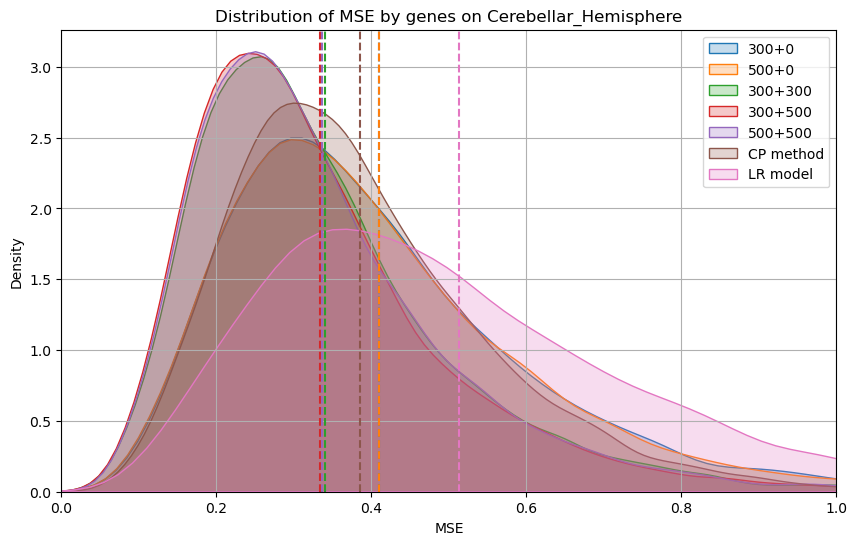

In [9]:
plt.figure(figsize=(10, 6))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']
GO_pars = [[300, 0], [500, 0], [300, 300], [300, 500], [500, 500]]
region = "Putamen_basal_ganglia"
real_mat = gen_real(region)
for n in range(5):
    t_epoch, f_epoch = GO_pars[n]
    GO_mat = gen_GO(t_epoch, f_epoch, region)
    mse_list, cor_list = metrics_by_gene(real_mat, GO_mat)
    sns.kdeplot(mse_list, color=colors[n], fill=True, label=f'{t_epoch}+{f_epoch}')
    mean_value = np.mean(mse_list)
    plt.axvline(x=mean_value, color=colors[n], linestyle='--', linewidth=1.5) 
# CP method
cp_mat = gen_cp(region, missing_N=0)
cp_mse, cp_cor = metrics_by_gene(real_mat, cp_mat)
sns.kdeplot(cp_mse, color=colors[5], fill=True, label='CP method')
mean_value = np.mean(cp_mse)
plt.axvline(x=mean_value, color=colors[5], linestyle='--', linewidth=1.5)
# lm model
lm_mat = gen_lm(summ_gtex_info, exp_gtex_dict, region, [r for r in region_pick if r!=region])
lm_mse, lm_cor = metrics_by_gene(real_mat, lm_mat)
sns.kdeplot(lm_mse, color=colors[6], fill=True, label='LR model')
mean_value = np.mean(lm_mse)
plt.axvline(x=mean_value, color=colors[6], linestyle='--', linewidth=1.5)

plt.title(f'Distribution of MSE by genes on {pick_gtex_region}')
plt.xlabel('MSE')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.xlim(0, 1)
plt.show()

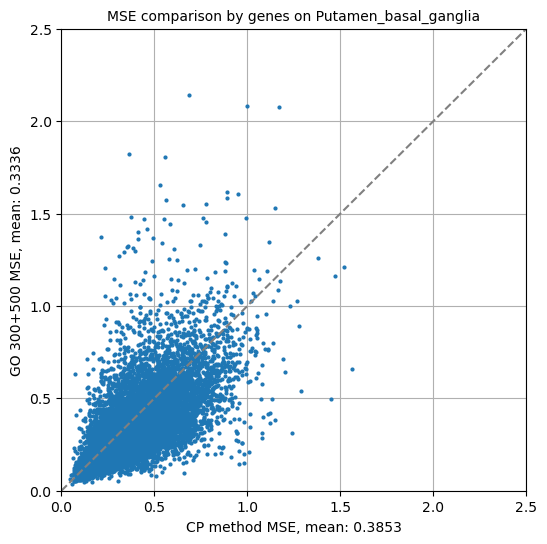

In [10]:
# Plotting the dot plot
plt.figure(figsize=(6, 6))
region = "Putamen_basal_ganglia"
real_mat = gen_real(region)
# CP method
cp_mat = gen_cp(region, missing_N=0)
cp_mse, cp_cor = metrics_by_gene(real_mat, cp_mat)
# GO model
t_epoch, f_epoch = 300, 500
GO_mat = gen_GO(t_epoch, f_epoch, region)
mse_list, cor_list = metrics_by_gene(real_mat, GO_mat)

plt.plot(cp_mse, mse_list, marker='o', linestyle='', markersize=2)
x_vector = np.array([0, 1, 2, 3])
plt.plot(x_vector, x_vector, color='grey', linestyle='--', label='y=x')
# Adding labels and title
plt.xlabel(f'CP method MSE, mean: {np.mean(cp_mse):.4f}')
plt.ylabel(f'GO 300+500 MSE, mean: {np.mean(mse_list):.4f}')
plt.title(f'MSE comparison by genes on {region}', size=10)
plt.xlim(0, 2.5)
plt.ylim(0, 2.5)
plt.grid(True)
plt.show()

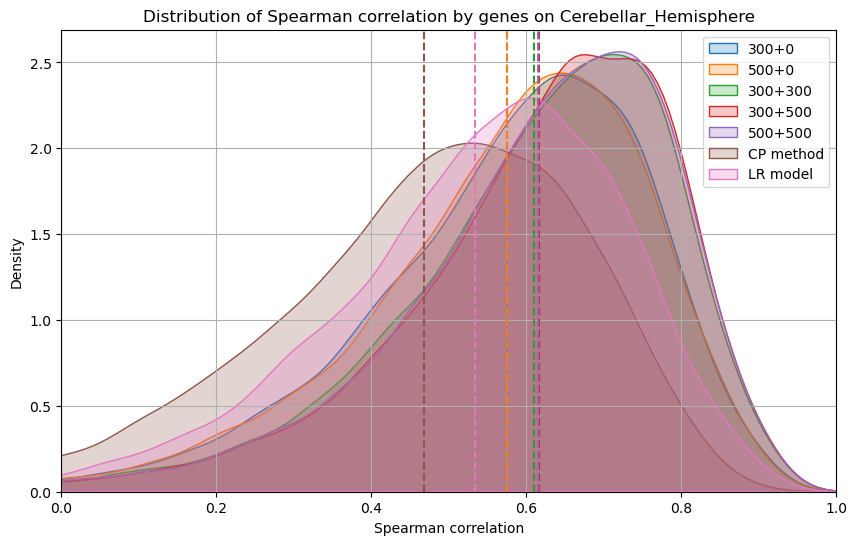

In [12]:
plt.figure(figsize=(10, 6))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']
GO_pars = [[300, 0], [500, 0], [300, 300], [300, 500], [500, 500]]
region = "Putamen_basal_ganglia"
real_mat = gen_real(region)
for n in range(5):
    t_epoch, f_epoch = GO_pars[n]
    GO_mat = gen_GO(t_epoch, f_epoch, region)
    mse_list, cor_list = metrics_by_gene(real_mat, GO_mat)
    sns.kdeplot(cor_list, color=colors[n], fill=True, label=f'{t_epoch}+{f_epoch}')
    mean_value = np.mean(cor_list)
    plt.axvline(x=mean_value, color=colors[n], linestyle='--', linewidth=1.5) 
# CP method
cp_mat = gen_cp(region, missing_N=0)
cp_mse, cp_cor = metrics_by_gene(real_mat, cp_mat)
sns.kdeplot(cp_cor, color=colors[5], fill=True, label='CP method')
mean_value = np.mean(cp_cor)
plt.axvline(x=mean_value, color=colors[5], linestyle='--', linewidth=1.5)
# lm model
lm_mat = gen_lm(summ_gtex_info, exp_gtex_dict, region, [r for r in region_pick if r!=region])
lm_mse, lm_cor = metrics_by_gene(real_mat, lm_mat)
sns.kdeplot(lm_cor, color=colors[6], fill=True, label='LR model')
mean_value = np.mean(lm_cor)
plt.axvline(x=mean_value, color=colors[6], linestyle='--', linewidth=1.5)

plt.title(f'Distribution of Spearman correlation by genes on {pick_gtex_region}')
plt.xlabel('Spearman correlation')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.xlim(0, 1)
plt.show()

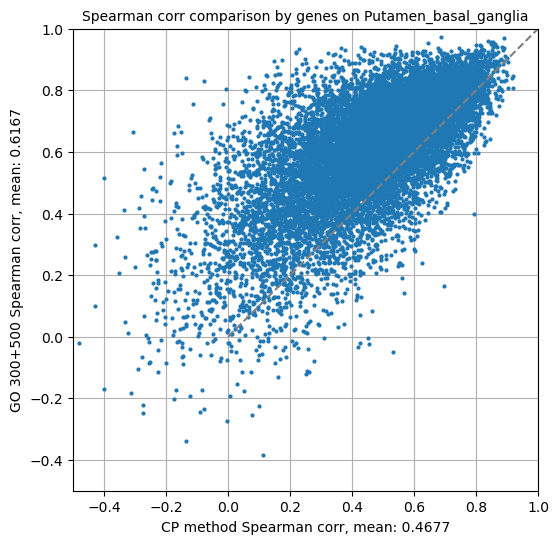

In [13]:
# Plotting the dot plot
plt.figure(figsize=(6, 6))
region = "Putamen_basal_ganglia"
real_mat = gen_real(region)
# CP method
cp_mat = gen_cp(region, missing_N=0)
cp_mse, cp_cor = metrics_by_gene(real_mat, cp_mat)
# GO model
t_epoch, f_epoch = 300, 500
GO_mat = gen_GO(t_epoch, f_epoch, region)
mse_list, cor_list = metrics_by_gene(real_mat, GO_mat)

plt.plot(cp_cor, cor_list, marker='o', linestyle='', markersize=2)
x_vector = np.array([0, 1, 2, 3])
plt.plot(x_vector, x_vector, color='grey', linestyle='--', label='y=x')
# Adding labels and title
plt.xlabel(f'CP method Spearman corr, mean: {np.mean(cp_cor):.4f}')
plt.ylabel(f'GO 300+500 Spearman corr, mean: {np.mean(cor_list):.4f}')
plt.title(f'Spearman corr comparison by genes on {region}', size=10)
plt.xlim(-0.5, 1)
plt.ylim(-0.5, 1)
plt.grid(True)
plt.show()

### CP method performance variation when running with different sets of subjects 

In [14]:
# # read the prediction from CP method
# pick_gtex_region = pick_gtex_region
# cp_result_dir = '/project/pi_rachel_melamed_uml_edu/Jianfeng/Allen/src/R/02072024/CP_results/'
    
# plt.figure(figsize=(10, 6))
# colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']
# # CP method running on subjects with different numbers of missing regions
# for n in range(6):
#     cp_mat = pred_mat_list[0].copy()
#     for subject in sub_all_ids:
#         cp_csv = f'{subject}_{pick_gtex_region}_{n}_20_0.5_0.5.csv'
#         cp_pred = pd.read_csv(cp_result_dir+cp_csv)['prediction'].tolist()
#         cp_mat[subject] = cp_pred
#     # compute mse and spearman corr
#     cp_mse, cp_cor = [], []
#     # iterate over genes
#     for g in range(cp_mat.shape[0]):
#         real_g_exp = np.array(real_mat.iloc[g,])
#         # CP method
#         cp_pred = np.array(cp_mat.iloc[g,])
#         mse = np.mean((cp_pred - real_g_exp) ** 2)
#         cor, p = spearmanr(cp_pred, real_g_exp)
#         cp_mse.append(mse)
#         cp_cor.append(cor)
#     # plot
#     sns.kdeplot(cp_mse, color=colors[n], fill=True, label=f'CP with missing_N={n}')
#     mean_value = np.mean(cp_mse)
#     plt.axvline(x=mean_value, color=colors[n], linestyle='--', linewidth=1.5)    
# # 300+500
# sns.kdeplot(model_300_500_mse, color=colors[6], fill=True, label='300+500')
# mean_value = np.mean(model_300_500_mse)
# plt.axvline(x=mean_value, color=colors[6], linestyle='--', linewidth=1.5)
# plt.title(f'Distribution of MSE by genes on {pick_gtex_region}', size=10)
# plt.xlabel('MSE')
# plt.ylabel('Density')
# plt.legend()
# plt.grid(True)
# plt.xlim(0, 1)
# plt.show()

In [15]:
# # read the prediction from CP method
# pick_gtex_region = pick_gtex_region
# cp_result_dir = '/project/pi_rachel_melamed_uml_edu/Jianfeng/Allen/src/R/02072024/CP_results/'
    
# plt.figure(figsize=(10, 6))
# colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']
# # CP method running on subjects with different numbers of missing regions
# for n in range(6):
#     cp_mat = pred_mat_list[0].copy()
#     for subject in sub_all_ids:
#         cp_csv = f'{subject}_{pick_gtex_region}_{n}_20_0.5_0.5.csv'
#         cp_pred = pd.read_csv(cp_result_dir+cp_csv)['prediction'].tolist()
#         cp_mat[subject] = cp_pred
#     # compute mse and spearman corr
#     cp_mse, cp_cor = [], []
#     # iterate over genes
#     for g in range(cp_mat.shape[0]):
#         real_g_exp = np.array(real_mat.iloc[g,])
#         # CP method
#         cp_pred = np.array(cp_mat.iloc[g,])
#         mse = np.mean((cp_pred - real_g_exp) ** 2)
#         cor, p = spearmanr(cp_pred, real_g_exp)
#         cp_mse.append(mse)
#         cp_cor.append(cor)
#     # plot
#     sns.kdeplot(cp_cor, color=colors[n], fill=True, label=f'CP with missing_N={n}')
#     mean_value = np.mean(cp_cor)
#     plt.axvline(x=mean_value, color=colors[n], linestyle='--', linewidth=1.5)    
# # 300+500
# sns.kdeplot(model_300_500_cor, color=colors[6], fill=True, label='300+500')
# mean_value = np.mean(model_300_500_cor)
# plt.axvline(x=mean_value, color=colors[6], linestyle='--', linewidth=1.5)
# plt.title(f'Distribution of Spearman correlation by genes on {pick_gtex_region}', size=10)
# plt.xlabel('Spearman correlation')
# plt.ylabel('Density')
# plt.legend()
# plt.grid(True)
# plt.xlim(0, 1)
# plt.show()

### MICE performance variation when running with different sets of subjects

/home/jianfeng_ke_student_uml_edu/.conda/envs/Allen_project_cuda/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


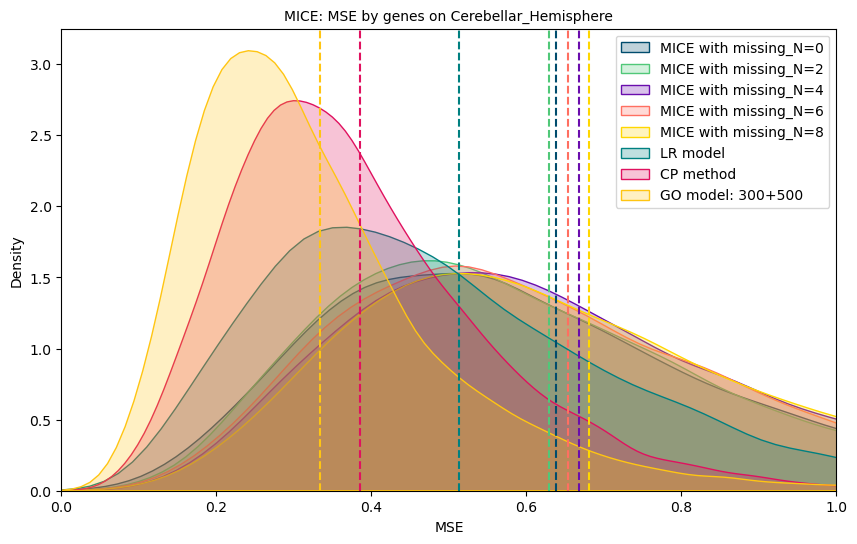

In [16]:
# generate the real expression data for the region
region = "Putamen_basal_ganglia"
real_mat = gen_real(region)
cp_mat = gen_cp(region, missing_N=0)
lm_mat = gen_lm(summ_gtex_info, exp_gtex_dict, region, [r for r in region_pick if r!=region])
t_epoch, f_epoch = 300, 500
go_mat = gen_GO(t_epoch, f_epoch, region)
# compute mse
lm_mse, lm_cor = metrics_by_gene(real_mat, lm_mat)
go_mse, go_cor = metrics_by_gene(real_mat, go_mat)
cp_mse, cp_cor = metrics_by_gene(real_mat, cp_mat)

colors = ['#004c6d', '#50c878', '#6a0dad', '#ff6f61', '#ffd700', '#008080', '#e0115f', '#ffc512']
# mice method
plt.figure(figsize=(10, 6))
for n in range(5):
    mice_mat = gen_mice(region, n*2)
    mice_mse, mice_cor = metrics_by_gene(real_mat, mice_mat)
    # plot
    sns.kdeplot(mice_mse, color=colors[n], fill=True, label=f'MICE with missing_N={n*2}')
    mean_value = np.mean(mice_mse)
    plt.axvline(x=mean_value, color=colors[n], linestyle='--', linewidth=1.5)   
# lm method
sns.kdeplot(lm_mse, color=colors[5], fill=True, label='LR model')
mean_value = np.mean(lm_mse)
plt.axvline(x=mean_value, color=colors[5], linestyle='--', linewidth=1.5)
# cp method
sns.kdeplot(cp_mse, color=colors[6], fill=True, label='CP method')
mean_value = np.mean(cp_mse)
plt.axvline(x=mean_value, color=colors[6], linestyle='--', linewidth=1.5)
# 300+500 GO model
sns.kdeplot(go_mse, color=colors[7], fill=True, label='GO model: 300+500')
mean_value = np.mean(go_mse)
plt.axvline(x=mean_value, color=colors[7], linestyle='--', linewidth=1.5)

plt.title(f'MICE: MSE by genes on {pick_gtex_region}', size=10)
plt.xlabel('MSE')
plt.ylabel('Density')
plt.legend()
plt.grid(False)
plt.xlim(0, 1)
plt.show()

/home/jianfeng_ke_student_uml_edu/.conda/envs/Allen_project_cuda/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


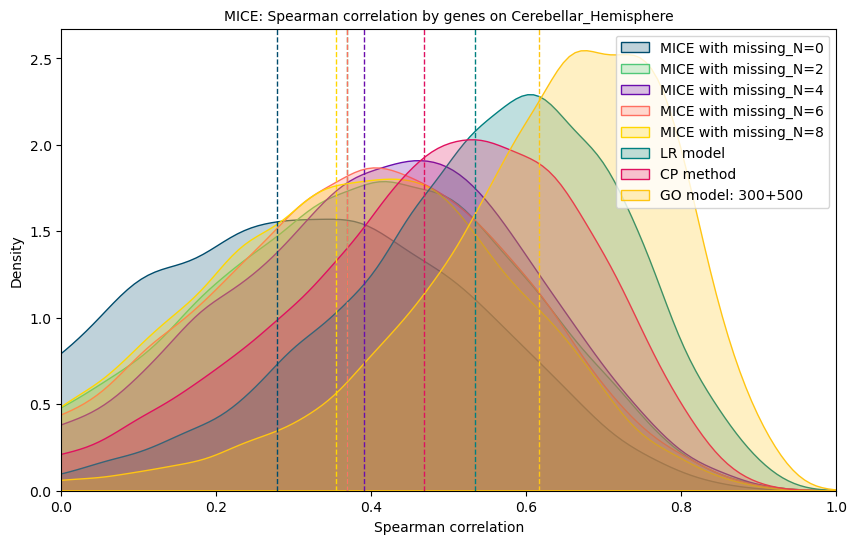

In [17]:
# generate the real expression data for the region
region = "Putamen_basal_ganglia"
real_mat = gen_real(region)
cp_mat = gen_cp(region, missing_N=0)
lm_mat = gen_lm(summ_gtex_info, exp_gtex_dict, region, [r for r in region_pick if r!=region])
t_epoch, f_epoch = 300, 500
go_mat = gen_GO(t_epoch, f_epoch, region)
# compute mse
lm_mse, lm_cor = metrics_by_gene(real_mat, lm_mat)
go_mse, go_cor = metrics_by_gene(real_mat, go_mat)
cp_mse, cp_cor = metrics_by_gene(real_mat, cp_mat)

colors = ['#004c6d', '#50c878', '#6a0dad', '#ff6f61', '#ffd700', '#008080', '#e0115f', '#ffc512']
# mice method
plt.figure(figsize=(10, 6))
for n in range(5):
    mice_mat = gen_mice(region, n*2)
    mice_mse, mice_cor = metrics_by_gene(real_mat, mice_mat)
    if n==0:
        x = [c for c in mice_cor if c is not np.nan]
        mice_cor = x
    # plot
    sns.kdeplot(mice_cor, color=colors[n], fill=True, label=f'MICE with missing_N={n*2}')
    mean_value = np.mean(mice_cor)
    plt.axvline(x=mean_value, color=colors[n], linestyle='--', linewidth=1)   
# lm method
sns.kdeplot(lm_cor, color=colors[5], fill=True, label='LR model')
mean_value = np.mean(lm_cor)
plt.axvline(x=mean_value, color=colors[5], linestyle='--', linewidth=1)
# cp method
sns.kdeplot(cp_cor, color=colors[6], fill=True, label='CP method')
mean_value = np.mean(cp_cor)
plt.axvline(x=mean_value, color=colors[6], linestyle='--', linewidth=1)
# 300+500 GO model
sns.kdeplot(go_cor, color=colors[7], fill=True, label='GO model: 300+500')
mean_value = np.mean(go_cor)
plt.axvline(x=mean_value, color=colors[7], linestyle='--', linewidth=1)

plt.title(f'MICE: Spearman correlation by genes on {pick_gtex_region}', size=10)
plt.xlabel('Spearman correlation')
plt.ylabel('Density')
plt.legend()
plt.grid(False)
plt.xlim(0, 1)
plt.show()

### Model performance comparison on different regions

/home/jianfeng_ke_student_uml_edu/.conda/envs/Allen_project_cuda/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


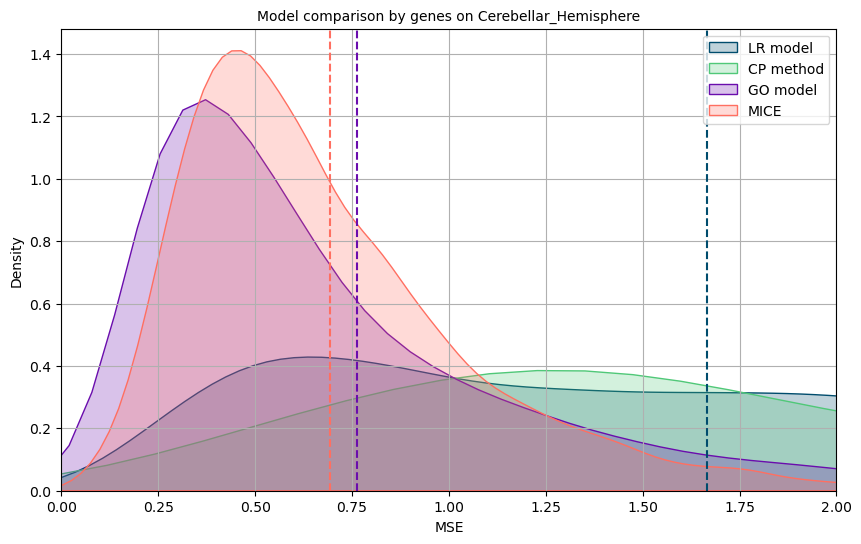

In [16]:
region_pick = ['Amygdala', 'Anterior_cingulate_cortex_BA24', 'Caudate_basal_ganglia', 
               'Cerebellar_Hemisphere', 'Frontal_Cortex_BA9', 'Hippocampus', 'Hypothalamus', 
               'Nucleus_accumbens_basal_ganglia', 'Putamen_basal_ganglia', 'Substantia_nigra']
region = region_pick[3]

real_mat = gen_real(region)
cp_mat = gen_cp(region, missing_N=5)
lm_mat = gen_lm(summ_gtex_info, exp_gtex_dict, region, [r for r in region_pick if r!=region])
t_epoch, f_epoch = 300, 500
keys = list(exp_allen_dict[all_ids[0]].columns)
go_mat = gen_GO(t_epoch, f_epoch, region)
mice_mat = gen_mice(region, missing_N=5)
# compute mse
lm_mse, lm_cor = metrics_by_gene(real_mat, lm_mat)
go_mse, go_cor = metrics_by_gene(real_mat, go_mat)
cp_mse, cp_cor = metrics_by_gene(real_mat, cp_mat)
mice_mse, mice_cor = metrics_by_gene(real_mat, mice_mat)
x = [c for c in mice_cor if c is not np.nan]
mice_cor = x

colors = ['#004c6d', '#50c878', '#6a0dad', '#ff6f61']
# mice method
plt.figure(figsize=(10, 6))
# lm method
sns.kdeplot(lm_mse, color=colors[0], fill=True, label='LR model')
mean_value = np.mean(lm_mse)
plt.axvline(x=mean_value, color=colors[0], linestyle='--', linewidth=1.5)
# cp method
sns.kdeplot(cp_mse, color=colors[1], fill=True, label='CP method')
# sns.kdeplot(cp_mse, color=colors[1], fill=True, label='CP: missing_N=0')
mean_value = np.mean(cp_mse)
plt.axvline(x=mean_value, color=colors[1], linestyle='--', linewidth=1.5)
# 300+500 GO model
sns.kdeplot(go_mse, color=colors[2], fill=True, label='GO model')
# sns.kdeplot(go_mse, color=colors[2], fill=True, label='GO model: 300+500')
mean_value = np.mean(go_mse)
plt.axvline(x=mean_value, color=colors[2], linestyle='--', linewidth=1.5)
# mice model
sns.kdeplot(mice_mse, color=colors[3], fill=True, label=f'MICE')
# sns.kdeplot(mice_mse, color=colors[3], fill=True, label=f'MICE: missing_N=0')
mean_value = np.mean(mice_mse)
plt.axvline(x=mean_value, color=colors[3], linestyle='--', linewidth=1.5)

plt.title(f'Model comparison by genes on {region}', size=10)
plt.xlabel('MSE')
plt.ylabel('Density')
plt.legend(loc='upper right')
plt.grid(True)
plt.xlim(0, 2)
plt.show()

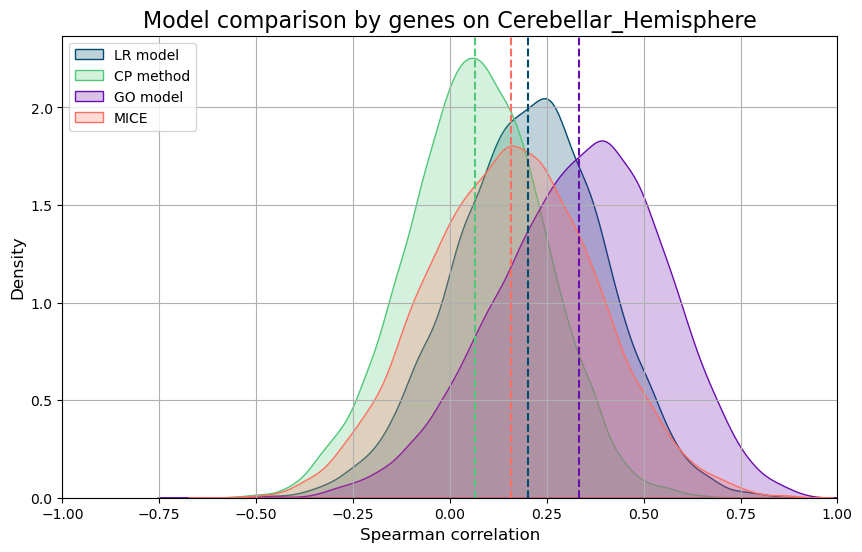

In [17]:
colors = ['#004c6d', '#50c878', '#6a0dad', '#ff6f61']
# mice method
plt.figure(figsize=(10, 6))
# lm method
sns.kdeplot(lm_cor, color=colors[0], fill=True, label='LR model')
mean_value = np.mean(lm_cor)
plt.axvline(x=mean_value, color=colors[0], linestyle='--', linewidth=1.5)
# cp method
sns.kdeplot(cp_cor, color=colors[1], fill=True, label='CP method')
# sns.kdeplot(cp_cor, color=colors[1], fill=True, label='CP: missing_N=0')
mean_value = np.mean(cp_cor)
plt.axvline(x=mean_value, color=colors[1], linestyle='--', linewidth=1.5)
# 300+500 GO model
sns.kdeplot(go_cor, color=colors[2], fill=True, label='GO model')
# sns.kdeplot(go_cor, color=colors[2], fill=True, label='GO model: 300+500')
mean_value = np.mean(go_cor)
plt.axvline(x=mean_value, color=colors[2], linestyle='--', linewidth=1.5)
# mice model
sns.kdeplot(mice_cor, color=colors[3], fill=True, label=f'MICE')
# sns.kdeplot(mice_cor, color=colors[3], fill=True, label=f'MICE: missing_N=0')
mean_value = np.mean(mice_cor)
plt.axvline(x=mean_value, color=colors[3], linestyle='--', linewidth=1.5)

plt.title(f'Model comparison by genes on {region}', size=16)
plt.xlabel('Spearman correlation', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend(loc='upper left')
plt.grid(True)
plt.xlim(-1, 1)
plt.show()

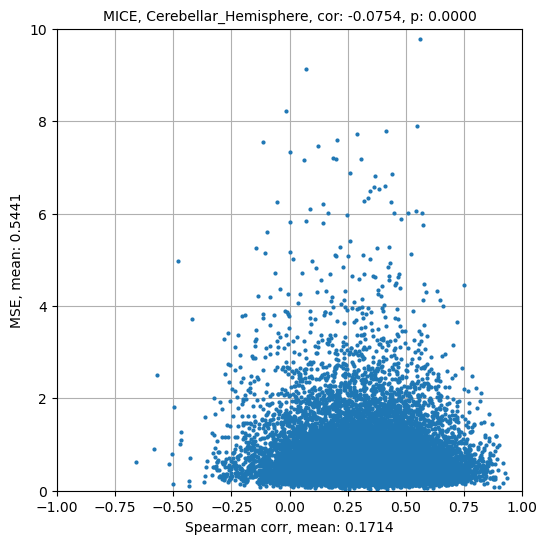

In [49]:
# Plotting the dot plot
plt.figure(figsize=(6, 6))
region = 'Cerebellar_Hemisphere'
real_mat = gen_real(region)
# # CP method
# cp_mat = gen_cp(region, missing_N=0)
# cp_mse, cp_cor = metrics_by_gene(real_mat, cp_mat)
# cor, p = spearmanr(cp_mse, cp_cor)
# plt.plot(cp_cor, cp_mse, marker='o', linestyle='', markersize=2)

# # GO model
t_epoch, f_epoch = 300, 500
GO_mat = gen_GO(t_epoch, f_epoch, region)
mse_list, cor_list = metrics_by_gene(real_mat, GO_mat)
cor, p = spearmanr(mse_list, cor_list)
plt.plot(cor_list, mse_list, marker='o', linestyle='', markersize=2)

# # LR model
# lm_mat = gen_lm(summ_gtex_info, exp_gtex_dict, region, [r for r in region_pick if r!=region])
# lm_mse, lm_cor = metrics_by_gene(real_mat, lm_mat)
# cor, p = spearmanr(lm_mse, lm_cor)
# plt.plot(lm_cor, lm_mse, marker='o', linestyle='', markersize=2)

# MICE
# mice_mat = gen_mice(region, missing_N=0)
# mice_mse, mice_cor = metrics_by_gene(real_mat, mice_mat)
# x = [c for c in mice_cor if c is not np.nan]
# mice_cor = x
# cor, p = spearmanr(mice_mse, mice_cor)
# plt.plot(mice_cor, mice_mse, marker='o', linestyle='', markersize=2)

#x_vector = np.array([-2, 0, 2])
#plt.plot(x_vector, x_vector, color='grey', linestyle='--', label='y=x')
# Adding labels and title
plt.xlabel(f'Spearman corr, mean: {np.mean(cp_cor):.4f}')
plt.ylabel(f'MSE, mean: {np.mean(cp_mse):.4f}')
plt.title(f'MICE, {region}, cor: {cor:.4f}, p: {p:.4f}', size=10)
plt.xlim(-1, 1)
plt.ylim(0, 10)
plt.grid(True)
plt.show()

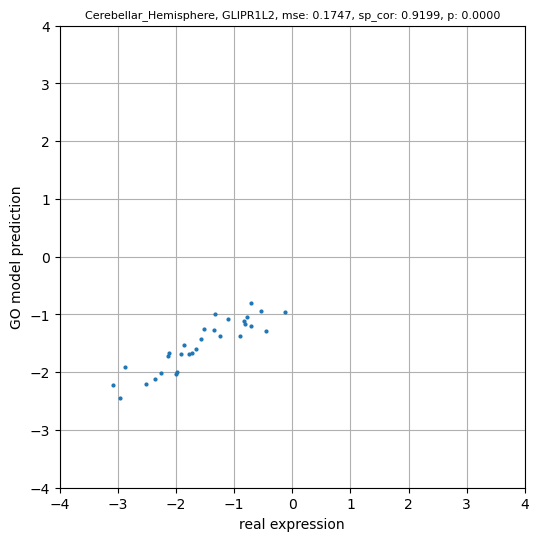

In [91]:
# GO model, ADCYAP1, low spearman correlation, low mse
# GO model, LGALS12, low spearman correlation, high mse
# GO model, NOL6, high spearman correlation, high mse
# GO model, GLIPR1L2, high spearman correlation, low mse
region = 'Cerebellar_Hemisphere'
real_mat = gen_real(region)
t_epoch, f_epoch = 300, 500
GO_mat = gen_GO(t_epoch, f_epoch, region)
gene = 'GLIPR1L2'
real_exp = real_mat.loc[gene]
go_pred = GO_mat.loc[gene]
# compute error
mse = np.mean((real_exp - go_pred) ** 2)
cor, p = spearmanr(real_exp, go_pred)

plt.figure(figsize=(6, 6))
plt.plot(real_exp, go_pred, marker='o', linestyle='', markersize=2)
plt.xlabel('real expression')
plt.ylabel(f'GO model prediction')
plt.title(f'{region}, {gene}, mse: {mse:.4f}, sp_cor: {cor:.4f}, p: {p:.4f}', size=8)
plt.xlim(-4, 4)
plt.ylim(-4, 4)
plt.grid(True)
plt.show()

### Model comparison with PrediXcan

In [95]:
def gen_predixcan(region):
    predixcan_dir = '/project/pi_rachel_melamed_uml_edu/Jianfeng/Allen/data/PrediXcan/result/'
    region_pick = ['Amygdala', 'Anterior_cingulate_cortex_BA24', 'Caudate_basal_ganglia', 
                   'Cerebellar_Hemisphere', 'Frontal_Cortex_BA9', 'Hippocampus', 'Hypothalamus', 
                   'Nucleus_accumbens_basal_ganglia', 'Putamen_basal_ganglia', 'Substantia_nigra']
    predict_filename = 'mashr_Brain_' + region + '_predict.txt'
    summary_filename = 'mashr_Brain_' + region + '_summary.txt'
    predict_data = pd.read_csv(predixcan_dir+predict_filename, low_memory=False, index_col=0, sep="\t")
    summary_data = pd.read_csv(predixcan_dir+summary_filename, low_memory=False, sep="\t")
    # gene code to gene name dictionary
    gene_name_dict = {}
    for i in range(len(summary_data['gene'])):
        gene = summary_data['gene'][i]
        gene_name = summary_data['gene_name'][i]
        gene_name_dict[gene] = gene_name
    # match gene code to gene name
    predict_data.columns = predict_data.columns.map(gene_name_dict.get)
    # remove duplicate id column
    predict_data = predict_data.iloc[:, 1:]
    # predict_data = predict_data.rename(columns={predict_data.columns[0]: 'ID'})
    predict_data = predict_data.T

    # count number of overlapped genes
    set1 = set(overlapped_gene_list)
    set2 = set(predict_data.index.tolist())
    PrediXcan_gene_list = list(set1 & set2)
    predict_data = predict_data.loc[PrediXcan_gene_list]
    # remove duplicate genes
    predict_data = predict_data.groupby(predict_data.index).mean()
    print(f'{len(set1 & set2)}/{predict_data.shape[0]} overlapped genes in {region}')
    PrediXcan_normed_df = predict_data.copy()

    # load gtex data of that region
    gtex_data = gt.loc[:, gt.iloc[0] == region]
    gtex_data = gtex_data.loc[predict_data.index].values.astype(float)
    for i in range(PrediXcan_normed_df.shape[0]):
        predixcan_value = predict_data.values[i]
        gtex_value_num = gtex_data[i]
        percentiles = norm.cdf(predixcan_value, loc=0, scale=1)
        mapped_data = np.percentile(gtex_value_num, percentiles * 100)
        PrediXcan_normed_df.iloc[i,:] = mapped_data
    
    return PrediXcan_normed_df

9759/9759 overlapped genes in Substantia_nigra


/home/jianfeng_ke_student_uml_edu/.conda/envs/Allen_project_cuda/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


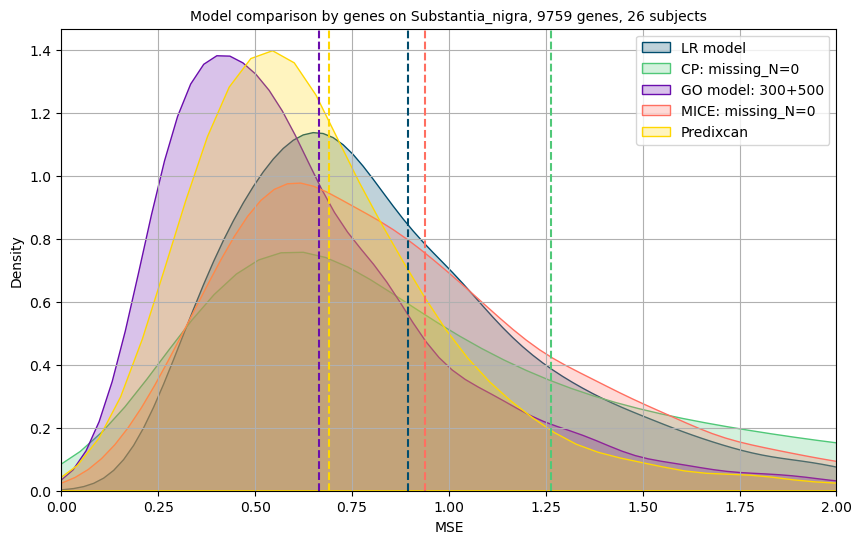

In [128]:
region_pick = ['Amygdala', 'Anterior_cingulate_cortex_BA24', 'Caudate_basal_ganglia', 
               'Cerebellar_Hemisphere', 'Frontal_Cortex_BA9', 'Hippocampus', 'Hypothalamus', 
               'Nucleus_accumbens_basal_ganglia', 'Putamen_basal_ganglia', 'Substantia_nigra']
region = region_pick[9]

predixcan_mat = gen_predixcan(region)
# find predixcan genes
include_subject = [x for x in sub_all_ids if x in predixcan_mat.columns]
predixcan_gene = predixcan_mat.index.tolist()
predixcan_mat = predixcan_mat[include_subject]

real_mat = gen_real(region)
cp_mat = gen_cp(region, missing_N=0)
lm_mat = gen_lm(summ_gtex_info, exp_gtex_dict, region, [r for r in region_pick if r!=region])
t_epoch, f_epoch = 300, 500
go_mat = gen_GO(t_epoch, f_epoch, region)
mice_mat = gen_mice(region, missing_N=0)

# only use predixcan genes and subjects
real_mat = real_mat[include_subject].loc[predixcan_gene]
cp_mat = cp_mat[include_subject].loc[predixcan_gene]
lm_mat = lm_mat[include_subject].loc[predixcan_gene]
go_mat = go_mat[include_subject].loc[predixcan_gene]
mice_mat = mice_mat[include_subject].loc[predixcan_gene]

# compute mse
lm_mse, lm_cor = metrics_by_gene(real_mat, lm_mat)
go_mse, go_cor = metrics_by_gene(real_mat, go_mat)
cp_mse, cp_cor = metrics_by_gene(real_mat, cp_mat)
mice_mse, mice_cor = metrics_by_gene(real_mat, mice_mat)
x = [c for c in mice_cor if c is not np.nan]
mice_cor = x
predixcan_mse, predixcan_cor = metrics_by_gene(real_mat, predixcan_mat)
x = [c for c in predixcan_cor if c is not np.nan]
predixcan_cor = x

colors = ['#004c6d', '#50c878', '#6a0dad', '#ff6f61', '#ffd700']

plt.figure(figsize=(10, 6))
# lm method
sns.kdeplot(lm_mse, color=colors[0], fill=True, label='LR model')
mean_value = np.mean(lm_mse)
plt.axvline(x=mean_value, color=colors[0], linestyle='--', linewidth=1.5)
# cp method
sns.kdeplot(cp_mse, color=colors[1], fill=True, label='CP: missing_N=0')
mean_value = np.mean(cp_mse)
plt.axvline(x=mean_value, color=colors[1], linestyle='--', linewidth=1.5)
# 300+500 GO model
sns.kdeplot(go_mse, color=colors[2], fill=True, label='GO model: 300+500')
mean_value = np.mean(go_mse)
plt.axvline(x=mean_value, color=colors[2], linestyle='--', linewidth=1.5)
# mice model
sns.kdeplot(mice_mse, color=colors[3], fill=True, label=f'MICE: missing_N=0')
mean_value = np.mean(mice_mse)
plt.axvline(x=mean_value, color=colors[3], linestyle='--', linewidth=1.5)
# predixcan result
sns.kdeplot(predixcan_mse, color=colors[4], fill=True, label='Predixcan')
mean_value = np.mean(predixcan_mse)
plt.axvline(x=mean_value, color=colors[4], linestyle='--', linewidth=1.5)

plt.title(f'Model comparison by genes on {region}, {len(predixcan_gene)} genes, {len(predixcan_subject)} subjects', size=10)
plt.xlabel('MSE')
plt.ylabel('Density')
plt.legend(loc='upper right')
plt.grid(True)
plt.xlim(0, 2)
plt.show()

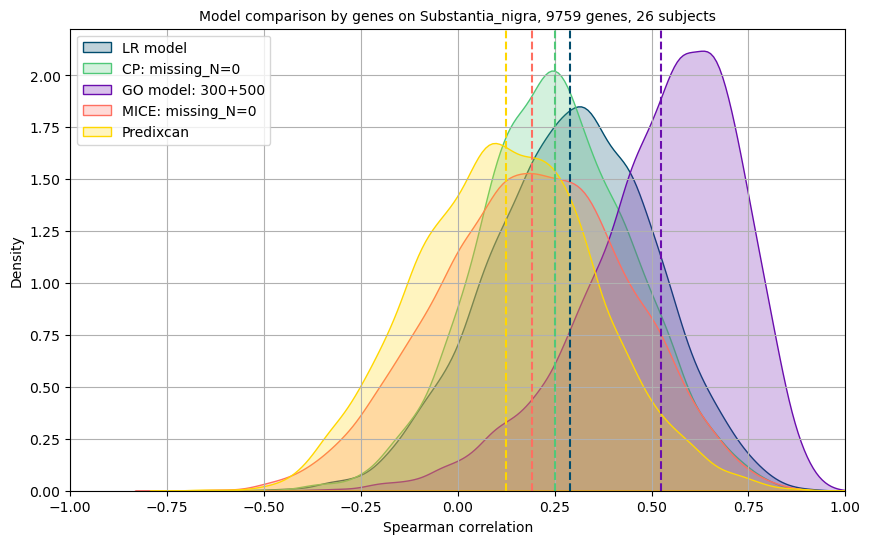

In [129]:
colors = ['#004c6d', '#50c878', '#6a0dad', '#ff6f61', '#ffd700']
# mice method
plt.figure(figsize=(10, 6))
# lm method
sns.kdeplot(lm_cor, color=colors[0], fill=True, label='LR model')
mean_value = np.mean(lm_cor)
plt.axvline(x=mean_value, color=colors[0], linestyle='--', linewidth=1.5)
# cp method
sns.kdeplot(cp_cor, color=colors[1], fill=True, label='CP: missing_N=0')
mean_value = np.mean(cp_cor)
plt.axvline(x=mean_value, color=colors[1], linestyle='--', linewidth=1.5)
# 300+500 GO model
sns.kdeplot(go_cor, color=colors[2], fill=True, label='GO model: 300+500')
mean_value = np.mean(go_cor)
plt.axvline(x=mean_value, color=colors[2], linestyle='--', linewidth=1.5)
# mice model
sns.kdeplot(mice_cor, color=colors[3], fill=True, label=f'MICE: missing_N=0')
mean_value = np.mean(mice_cor)
plt.axvline(x=mean_value, color=colors[3], linestyle='--', linewidth=1.5)
# predixcan result
sns.kdeplot(predixcan_cor, color=colors[4], fill=True, label='Predixcan')
mean_value = np.mean(predixcan_cor)
plt.axvline(x=mean_value, color=colors[4], linestyle='--', linewidth=1.5)

plt.title(f'Model comparison by genes on {region}, {len(predixcan_gene)} genes, {len(predixcan_subject)} subjects', size=10)
plt.xlabel('Spearman correlation')
plt.ylabel('Density')
plt.legend(loc='upper left')
plt.grid(True)
plt.xlim(-1, 1)
plt.show()